## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
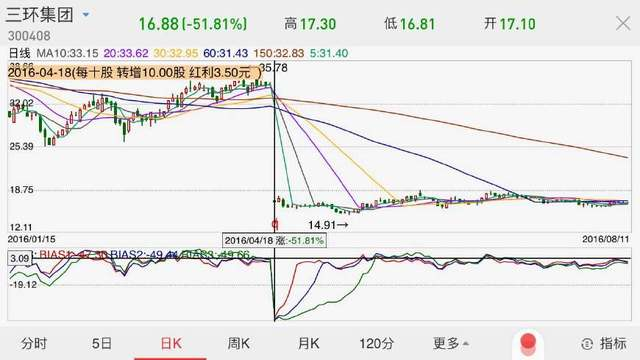

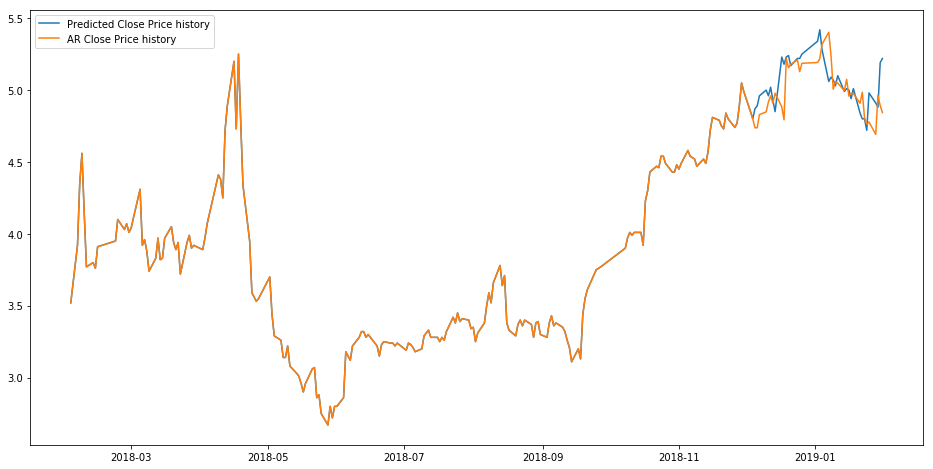

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

项目目标： 训练一个RNN网络；可以识别名字主人的国际

（1） 输入： 名字 
（2） 输出： 国籍

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob         #python的glob模块可以对文件夹下所有文件进行遍历，并保存为一个list列表
import os
import matplotlib.pyplot as plt

def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

构建Ascii码转化函数

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}   #存储每个类别key 对于的姓名 values  
all_categories = []   #存储国家类别

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')     #lines是列表，存储每个国家的名字
    return [unicode_2_Ascii(line) for line in lines]                      # 对名字进行 编码处理

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]             #取出文件名的国家类别字段
    all_categories.append(category)                                         
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
n_categories

18

In [6]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

In [7]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

### 1.4 这一次我们使用pytorch, 来进行向量化

相当于： 一个名字由n个字母组成，每个字母是一个 1×57的张量 ； 
包括大小写 a - z为 0-25 ； J 为35 
one-hot 表示

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones'))
print(line_to_tensor('Jones').size())         # 5个字母 ； 1×57 的张量

35
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

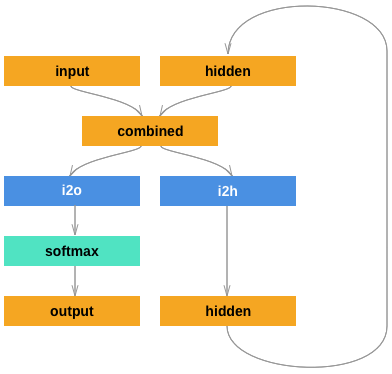

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): 
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  #线性变换  input+hidden 维度 × hidden维度 没有bias
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # nn.linear （input的列（特征数），output的列（特征数））
        self.softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # 拼接 input 和 hidden ； 1代表横着拼（列+ and 行不变）； 0代表竖着拼（行+ and 列不变）
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):        #初始化hidden成
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [10]:
rnn = RNN(n_letters, n_hidden, n_categories)   #字母维度

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [11]:
input = letter_to_tensor('Jones')
print(input.size())
hidden =torch.zeros(1, n_hidden)
print(hidden.size())
output, next_hidden = rnn(input, hidden)


torch.Size([1, 57])
torch.Size([1, 128])


In [12]:
output

tensor([[-2.8840, -2.7815, -2.8275, -2.7949, -2.8811, -2.8936, -2.8838, -2.8205,
         -2.9143, -2.9533, -2.8793, -2.8828, -2.9443, -3.0202, -2.9797, -2.9214,
         -2.8905, -2.9056]], grad_fn=<LogSoftmaxBackward>)

In [13]:
next_hidden

tensor([[ 0.0230,  0.1171,  0.0425, -0.0538, -0.0523,  0.0884,  0.0937, -0.0277,
          0.1353,  0.0405,  0.0480, -0.1124,  0.0014, -0.0845,  0.0769, -0.0892,
          0.0132,  0.0402, -0.0283,  0.0857, -0.0489, -0.1420, -0.0685, -0.0873,
          0.0144, -0.0441,  0.0201, -0.0216,  0.0313, -0.1003, -0.0821,  0.0891,
         -0.0401, -0.0073,  0.0620, -0.0215,  0.0127, -0.0220,  0.1120, -0.0064,
         -0.0211, -0.0210,  0.0008, -0.0375, -0.0703, -0.0637, -0.0063, -0.0094,
          0.0054,  0.0763, -0.0226,  0.0595,  0.0562,  0.0047, -0.0529, -0.0820,
          0.0705,  0.0099, -0.1057, -0.0342,  0.0340, -0.0551,  0.0262, -0.0893,
          0.0362, -0.0919, -0.0028, -0.0478,  0.0235, -0.0386,  0.0833,  0.0510,
          0.0190, -0.0438, -0.0062,  0.0247, -0.0137,  0.0516, -0.0294,  0.0140,
          0.1106,  0.0002, -0.1340,  0.0637, -0.0565,  0.0892, -0.0206,  0.0406,
         -0.1056,  0.0787, -0.0902, -0.0853, -0.0339, -0.0176, -0.0269,  0.0399,
          0.0101,  0.0126,  

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [15]:
input = line_to_tensor('Wang')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9361, -2.7709, -2.8053, -2.8667, -2.9473, -2.8389, -2.8071, -2.8640,
         -2.9540, -2.9323, -2.7918, -2.8422, -2.9255, -2.9372, -3.0296, -2.9717,
         -2.9863, -2.8672]], grad_fn=<LogSoftmaxBackward>)


In [16]:
input[1]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [17]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i     #取字典中的关键字



对于刚刚产生的output，我们使用这个函数

In [18]:
print(category_from_output(output))

('Chinese', 1)


### 1.8 随机生成训练数据

In [19]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)           # 随机取 国家
    line = sample(category_lines[category])     # 随机取 该国家对应的人名
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # 转化成向量
    line_tensor = line_to_tensor(line)                                                  # 转化成向量
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = German / line = Oberst
category = Italian / line = Baldovini
category = Russian / line = Prigojy
category = Scottish / line = Whyte
category = Scottish / line = Henderson
category = German / line = Schuhart
category = Spanish / line = Jaso
category = Czech / line = Kriz
category = English / line = Leadley
category = Dutch / line = Romeijn


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [20]:
criterion = nn.CrossEntropyLoss()   #选择交叉熵做loss funtion

In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):               #遍历一个单词的所有字母,输入到 run
        output, hidden = rnn(line_tensor[i], hidden)     # 遍历一个单词后，输出out 和 hidden    

    loss = criterion(output, category_tensor)           # 遍历一个单词后，输出out 和 标签向量；输入loss-funtion
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():                         # 参数 ×学习率
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [22]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 2s) 2.7633 Mo / Korean ✓
1000 10% (0m 4s) 2.7065 Do / Vietnamese ✓
1500 15% (0m 6s) 2.7950 Ko / Vietnamese ✗ (Korean)
2000 20% (0m 8s) 2.6728 Dang / Vietnamese ✓
2500 25% (0m 10s) 2.7558 Allan / Irish ✗ (Scottish)
3000 30% (0m 12s) 2.9965 Lee / French ✗ (Korean)
3500 35% (0m 14s) 2.4145 Malinowski / Irish ✗ (Polish)
4000 40% (0m 16s) 2.3861 Guo / Chinese ✓
4500 45% (0m 18s) 1.7031 Filipowski / Polish ✓
5000 50% (0m 19s) 2.8952 Stumpf / Portuguese ✗ (German)
5500 55% (0m 21s) 2.7240 David / Arabic ✗ (French)
6000 60% (0m 23s) 1.3132 Papadelias / Greek ✓
6500 65% (0m 26s) 2.9756 Hafernik / Polish ✗ (Czech)
7000 70% (0m 28s) 3.0396 Hall / Chinese ✗ (German)
7500 75% (0m 29s) 2.7009 Tracey / Arabic ✗ (Irish)
8000 80% (0m 31s) 1.9938 Egger / German ✓
8500 85% (0m 33s) 2.6135 Dingle / French ✗ (English)
9000 90% (0m 35s) 1.7330 Ma / Korean ✓
9500 95% (0m 37s) 2.0144 Gonzalez / Spanish ✓
10000 100% (0m 39s) 2.8361 Magalhaes / Greek ✗ (Portuguese)


### 1.9 观察Loss的变化

In [23]:
all_losses

[2.8828377890586854,
 2.880565116405487,
 2.880518536567688,
 2.865286009311676,
 2.8604211163520814,
 2.8538852190971373,
 2.85698890209198,
 2.866016345024109,
 2.8424671602249147,
 2.8450313806533813,
 2.855901017189026,
 2.8375948095321655,
 2.8223668432235716,
 2.8132494950294493,
 2.815604815483093,
 2.8203101682662965,
 2.775230371952057,
 2.8043549966812136,
 2.806728479862213,
 2.8036517024040224,
 2.7901002264022825,
 2.752614758014679,
 2.7642777967453003,
 2.752079954147339,
 2.7602894377708433,
 2.732485625743866,
 2.7346171879768373,
 2.731352331638336,
 2.750685896873474,
 2.72242754817009,
 2.7042160058021545,
 2.644251751899719,
 2.693810032606125,
 2.647434346675873,
 2.6456261646747588,
 2.658476277589798,
 2.59147271156311,
 2.616924602985382,
 2.5534512877464293,
 2.5955826938152313,
 2.600244265794754,
 2.606318312883377,
 2.5742238771915438,
 2.542839843034744,
 2.498214294910431,
 2.5405075538158415,
 2.479934665560722,
 2.442215187549591,
 2.4289515054225923,
 

In [24]:
%matplotlib inline

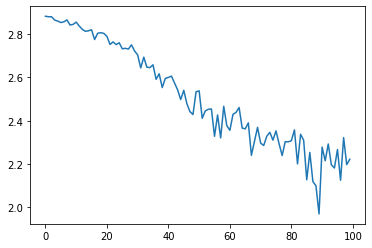

In [25]:
plt.plot(all_losses)

用训练好的RNN预测

In [26]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Li')
predict('Rukawa')  # 流川枫
predict('Sheldon')


> Li
(-1.61) Korean
(-1.62) Chinese
(-1.66) Vietnamese

> Rukawa
(-1.39) Japanese
(-2.45) Spanish
(-2.65) Czech

> Sheldon
(-1.90) Scottish
(-2.19) Russian
(-2.32) English


结果：比较准确，识别出 li 是中文或者韩国名； 流川枫是日本名

## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

###  修改RNN模型（加更多的层）

修改 forwrad函数； 用上一层i2o和iho的输出，当作下一层i2o和iho的输入     

增加了2层，一共3层


In [27]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): 
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
                       
        self.i2h_1 = nn.Linear(input_size + hidden_size, hidden_size)    #第1层初始化 
        self.i2o_1 = nn.Linear(input_size + hidden_size, output_size)  
                
        
        self.i2h_2 = nn.Linear(128, hidden_size)   #第2层初始化 
        self.i2o_2 = nn.Linear(18, output_size) 
        
        self.i2h_3 = nn.Linear(128, hidden_size)   #第3层初始化 
        self.i2o_3 = nn.Linear(18, output_size) 
        
        
        self.softmax = nn.LogSoftmax(dim=1)        #log 输出小于0 dim=1代表对第二维的数据操作
                               
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # 拼接 input 和 hidden ； 1代表横着拼（列+ and 行不变）； 0代表竖着拼（行+ and 列不变）
        hidden_1 = self.i2h_1(combined)
        output_1 = self.i2o_1(combined)                          #第1层
        
        hidden_2 = self.i2h_2(hidden_1)
        output_2 = self.i2o_2(output_1)                          #第2层
        
        hidden_3 = self.i2h_3(hidden_2)
        output_3 = self.i2o_3(output_2)                          #第3层
        
                       
        hidden = hidden_3
        output = self.softmax(output_3)
        
        return output, hidden

    def initHidden(self):        #初始化hidden成
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [28]:
rnn_layers = RNN(n_letters, n_hidden, n_categories)   #字母维度

In [29]:
criterion = nn.CrossEntropyLoss()   #选择交叉熵做loss funtion

In [30]:
learning_rate = 0.000005 # 学习率缩小了1000倍

def train_layers(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量
    hidden = rnn_layers.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_layers(line_tensor[i], hidden)         #遍历一个单词的所有字母,输入到 run

    loss = criterion(output, category_tensor)                  
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_layers.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [31]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train_layers(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 4s) 2.9457 Koustoubos / English ✗ (Greek)
1000 10% (0m 9s) 2.8800 Nassar / English ✗ (Arabic)
1500 15% (0m 13s) 2.7719 Drivakis / Chinese ✗ (Greek)
2000 20% (0m 17s) 2.9978 Cloutier / Polish ✗ (French)
2500 25% (0m 21s) 2.8439 Dupond / Polish ✗ (French)
3000 30% (0m 25s) 2.5523 Serafin / Polish ✓
3500 35% (0m 29s) 2.7263 Thuy / Polish ✗ (Vietnamese)
4000 40% (0m 33s) 2.9581 Zheng / French ✗ (Chinese)
4500 45% (0m 38s) 2.9022 Chapman / Japanese ✗ (English)
5000 50% (0m 42s) 2.8224 Le / Japanese ✗ (Vietnamese)
5500 55% (0m 47s) 2.8120 Law / Japanese ✗ (Chinese)
6000 60% (0m 51s) 2.7009 Fowler / Russian ✗ (English)
6500 65% (0m 55s) 3.1763 Vo / Russian ✗ (Vietnamese)
7000 70% (0m 59s) 0.3572 Maneates / Greek ✓
7500 75% (1m 3s) 2.6002 Martin / Irish ✗ (French)
8000 80% (1m 7s) 2.7061 Raskop / Russian ✗ (German)
8500 85% (1m 12s) 1.7913 Schermer / Russian ✗ (Dutch)
9000 90% (1m 16s) 1.8918 Phung / Chinese ✗ (Vietnamese)
9500 95% (1m 20s) 1.9988 Bradach / Irish ✓
10000 100% (1m 24

In [32]:
all_losses

[2.9008944463729858,
 2.8842313432693483,
 2.926833198070526,
 2.907175159454346,
 2.909895975589752,
 2.8983874106407166,
 2.8952627611160278,
 2.8884843826293944,
 2.9032340621948243,
 2.8951365780830383,
 2.9129821062088013,
 2.899052879810333,
 2.8958888626098633,
 2.89432808637619,
 2.9197681069374086,
 2.9095321464538575,
 2.8713649916648865,
 2.8966688346862792,
 2.885861897468567,
 2.8834043383598327,
 2.879046821594238,
 2.9007275176048277,
 2.8784059166908262,
 2.865560212135315,
 2.9003310084342955,
 2.9035556387901305,
 2.9025085401535033,
 2.881120526790619,
 2.8678653240203857,
 2.8872257542610167,
 2.8703615403175355,
 2.9204608845710753,
 2.8977222299575804,
 2.893095715045929,
 2.857083809375763,
 2.8583284997940064,
 2.9152222514152526,
 2.8903995394706725,
 2.8605559182167055,
 2.8760835480690004,
 2.85501914024353,
 2.8711281776428224,
 2.8461972761154173,
 2.8383517765998842,
 2.8603281354904175,
 2.8582721972465515,
 2.854344410896301,
 2.7902912306785583,
 2.8326

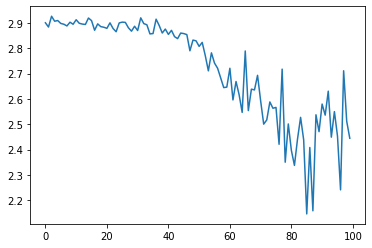

In [33]:
plt.plot(all_losses)

### step3 预测结果

In [36]:
def evaluate_layers(line_tensor):
    hidden = rnn_layers.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_layers(line_tensor[i], hidden)
    return output

def predict_layers(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_layers(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict_layers('Wang')
predict_layers('Sakuragi')  # 樱木花道
predict_layers('Sheldon')


> Wang
(-0.36) Chinese
(-2.16) Korean
(-2.31) Vietnamese

> Sakuragi
(-0.63) Italian
(-1.33) Polish
(-2.72) Czech

> Sheldon
(-1.33) Russian
(-2.09) German
(-2.15) English


### 结果对比：  

 RNN ： 1层rnn ；1层i2o和i2h  学习率0.005； 10000轮运行时间 39s ； loss 2.1左右 

 RNN_layers： 1层rnn ；3层i2o和i2h 学习率 0.000005 ； 10000轮运行时间 1m24s ； loss2.4左右，波动大

 结论： 在RNN中，增加i2h和i2o的迭代层数，并不是性价比很高的做法，运算时间翻倍，loss效果未有明显改善；同时需要大幅度降低学习率规避梯度爆炸，否则loss输出“nan”的结果



### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化


input(seq_len, batch, input_size)

h_0(num_layers * num_directions, batch, hidden_size)

c_0(num_layers * num_directions, batch, hidden_size)
 
构建input ，input是三个维度（seq_len ， batch_size ， inp_dim）本例中的映射关系：

seq_len 代表： 一个词的字母数量
batch_size 代表 ： 一个组成词的最小单元，为1 一个字母
inp_dim 代表 ： 一个字母的特征维度数 ， 为 57

h0 = torch.randn(1, 1, 128)  代表 ： 1层 ，最小单元1 ， 128个维度 （同上例）
c0 = torch.randn(1, 1, 128)

 

In [37]:
import torch
import torch.nn as nn             # 神经网络模块
from torch.autograd import Variable

In [38]:
rnn_lstm = nn.LSTM(57, 128,1)   # input 57维 ；hidden 128维 同上例 ；1层rnn

In [52]:
learning_rate = 0.05 # If you set this too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量

    rnn_lstm.zero_grad()
    
    input = line_tensor                         # input (seq , batch_size , inp_dim )
    h0 = Variable(torch.randn(1, 1, 128))       # 定义初始化隐藏状态
    c0 = Variable(torch.randn(1, 1, 128))       # 定义初始化细胞状态
        
    output, hidden = rnn_lstm(input,(h0,c0))    # output (seq , batch_size , 128维 )

    for i in range(output.size()[0]):          # 这里需要进行维度变换处理 
        output_1 = output[i] 
        output_2 = i2o(output_1)               # 线性变换 128 -> 18
        output_3 = softmax(output_2)           # softmax激活
   
    loss = criterion(output_3, category_tensor)      
    loss.backward(retain_graph=True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [53]:
criterion = nn.CrossEntropyLoss()   #选择交叉熵做loss funtion

In [54]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

i2o = nn.Linear(128, 18)  
softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作
def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()    
    output, loss = train_lstm(category_tensor, line_tensor)                                   
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 4s) 2.9701 To / Chinese ✗ (Vietnamese)
1000 10% (0m 8s) 2.8113 Hao / Greek ✗ (Chinese)
1500 15% (0m 12s) 2.8611 Basurto / Greek ✗ (Portuguese)
2000 20% (0m 16s) 2.8199 Chung / Greek ✗ (English)
2500 25% (0m 19s) 2.9990 Vinh / English ✗ (Vietnamese)
3000 30% (0m 23s) 2.9890 Maurice / English ✗ (Irish)
3500 35% (0m 27s) 2.7968 Yoshida / Portuguese ✗ (Japanese)
4000 40% (0m 31s) 2.5533 Mai / Chinese ✓
4500 45% (0m 35s) 2.6029 Gaspar / Greek ✗ (Portuguese)
5000 50% (0m 39s) 2.9331 Kawate / Portuguese ✗ (Japanese)
5500 55% (0m 43s) 2.5497 Yap / Chinese ✓
6000 60% (0m 47s) 2.8496 Noh / Chinese ✗ (Korean)
6500 65% (0m 51s) 2.4623 Pereira / Italian ✗ (Portuguese)
7000 70% (0m 55s) 2.4898 Okui / Japanese ✓
7500 75% (0m 59s) 2.9000 Silje / Scottish ✗ (Dutch)
8000 80% (1m 3s) 3.2332 Rodrigues / Czech ✗ (Portuguese)
8500 85% (1m 6s) 3.0558 Herrero / German ✗ (Spanish)
9000 90% (1m 10s) 2.6833 Tahan / Chinese ✗ (Arabic)
9500 95% (1m 14s) 2.9831 Rowlinson / Russian ✗ (English)
10000 100% 

In [55]:
all_losses

[2.884230606555939,
 2.8925408148765563,
 2.880922186374664,
 2.894754319190979,
 2.890762810707092,
 2.888123013973236,
 2.8777823853492737,
 2.872011971473694,
 2.8764064717292785,
 2.875234553813934,
 2.8743127512931825,
 2.8700870156288145,
 2.8888343739509583,
 2.8782526683807372,
 2.8678726887702943,
 2.863988547325134,
 2.8758234930038453,
 2.854001622200012,
 2.855983917713165,
 2.877698490619659,
 2.8522660779953,
 2.855739438533783,
 2.8501676392555235,
 2.829185345172882,
 2.845867466926575,
 2.862861785888672,
 2.844169759750366,
 2.854409279823303,
 2.862678005695343,
 2.837214114665985,
 2.8359570693969727,
 2.8376462841033936,
 2.8333638167381285,
 2.8096305537223816,
 2.8113989663124084,
 2.791953537464142,
 2.8104700016975404,
 2.7984420037269593,
 2.774841284751892,
 2.7703647446632385,
 2.8159423017501832,
 2.7852237749099733,
 2.796838083267212,
 2.7316981709003447,
 2.783066977262497,
 2.8073752188682555,
 2.795537111759186,
 2.794607074260712,
 2.7642807388305664,

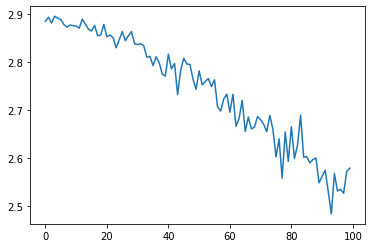

In [56]:
plt.plot(all_losses)

LSTM 学习率需要调整到0.05 ，才能有比较好的效果 ； 学习率0.005会出现在局部区间震荡的情况；

In [81]:
import torch
import torch.nn as nn             # 神经网络模块
from torch.autograd import Variable

In [82]:
rnn_GRU = nn.GRU(57, 128,1)   #字母维度

In [83]:
learning_rate = 0.05 # If you set this too high, it might explode. If too low, it might not learn

def train_GRU(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量

    rnn_GRU.zero_grad()
    
    input = line_tensor                         # input (seq , batch_size , inp_dim )        
    output, hidden = rnn_GRU(input)    # output (seq , batch_size , 128维 )
    
        

    for i in range(output.size()[0]):
        output_1 = output[i] 
        output_2 = i2o(output_1)
        output_3 = softmax(output_2)
   
    loss = criterion(output_3, category_tensor)      
    loss.backward(retain_graph=True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_GRU.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [84]:
criterion = nn.CrossEntropyLoss()   #选择交叉熵做loss funtion

In [85]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

i2o = nn.Linear(128, 18)
softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()    
    output, loss = train_GRU(category_tensor, line_tensor)                                   
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 4s) 2.7795 Bernard / Irish ✗ (Polish)
1000 10% (0m 8s) 2.8574 Shaw / Italian ✗ (Scottish)
1500 15% (0m 12s) 2.7745 Bing / Irish ✗ (Chinese)
2000 20% (0m 16s) 2.7781 Alst / Greek ✗ (Dutch)
2500 25% (0m 20s) 2.9222 Barone / French ✗ (Italian)
3000 30% (0m 24s) 2.6620 Bui / Vietnamese ✓
3500 35% (0m 28s) 1.8746 Fotopoulos / Greek ✓
4000 40% (0m 32s) 2.5446 Uemlyanin / Scottish ✗ (Russian)
4500 45% (0m 36s) 1.1304 Antimisiaris / Greek ✓
5000 50% (0m 40s) 1.8214 Van / Vietnamese ✓
5500 55% (0m 44s) 2.7614 Craig / Arabic ✗ (Scottish)
6000 60% (0m 48s) 1.9761 Yeo / Korean ✓
6500 65% (0m 51s) 2.4031 Heel / Korean ✗ (Dutch)
7000 70% (0m 55s) 1.9797 Sullivan / Greek ✗ (Irish)
7500 75% (0m 59s) 3.1974 Entler / Dutch ✗ (Czech)
8000 80% (1m 3s) 2.6633 Urista / Portuguese ✗ (Czech)
8500 85% (1m 7s) 3.0954 Vann / Chinese ✗ (Dutch)
9000 90% (1m 11s) 2.2719 Arato / Portuguese ✗ (Japanese)
9500 95% (1m 15s) 1.5957 Snyders / Dutch ✓
10000 100% (1m 19s) 1.7266 Nolan / Irish ✓


In [86]:
all_losses

[2.886203827857971,
 2.8893011164665223,
 2.878663189411163,
 2.8753153109550476,
 2.868284685611725,
 2.8784373927116396,
 2.8682580399513244,
 2.8697044801712037,
 2.84696364402771,
 2.872943606376648,
 2.8312867856025696,
 2.8381829690933227,
 2.821156630516052,
 2.8587143325805666,
 2.833063099384308,
 2.8410452818870544,
 2.803296802043915,
 2.80999986410141,
 2.7969310593605043,
 2.7410639715194702,
 2.8091253995895387,
 2.7983687114715576,
 2.793214635848999,
 2.785450267791748,
 2.782379107475281,
 2.7584121894836424,
 2.7560793590545654,
 2.712156653404236,
 2.7452342450618743,
 2.695059750080109,
 2.636406238079071,
 2.62557510137558,
 2.696740769147873,
 2.692333382368088,
 2.6361191737651826,
 2.643923953771591,
 2.6398771262168883,
 2.6153460109233855,
 2.6594025576114655,
 2.621149710416794,
 2.5442654812335967,
 2.6534948325157166,
 2.5673862886428833,
 2.577746114730835,
 2.4859109807014463,
 2.570456839799881,
 2.4904762637615203,
 2.4710650181770326,
 2.48100435018539

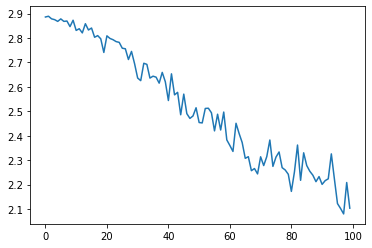

In [87]:
plt.plot(all_losses)

### 结果对比：  

 LSTM： 1层rnn ；学习率0.05； 10000轮运行时间 1m18s ； loss 2.4左右 

 GRU： 1层rnn ； 学习率 0.05 ； 10000轮运行时间 1m19s ； loss2.1左右

 结论： LSTM和GRU相比RNN学习率需要调到0.05，不然会出现梯度消失，再loss某个区间内震荡；整体性能上，运算时间两个种方式差不多，效果上本例而言，GRU比LSTM有更低的loss

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [89]:
import torch
import torch.nn as nn             # 神经网络模块

In [90]:
rnn_n = nn.RNN(57, 128,3)         # input 57维 ；hidden 128维  ；3层rnn

In [96]:
learning_rate = 0.0005 # If you set this too high, it might explode. If too low, it might not learn

def train_n(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量

    rnn_n.zero_grad()
    input = line_tensor    
    output, hidden = rnn_n(input) 

    for i in range(output.size()[0]):
        output_1 = output[i] 
        output_2 = i2o(output_1)
        output_3 = softmax(output_2)
   
    loss = criterion(output_3, category_tensor)      
    loss.backward(retain_graph=True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_n.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [97]:
criterion = nn.CrossEntropyLoss()   #选择交叉熵做loss funtion

In [98]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

i2o = nn.Linear(128, 18)
softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()    
    output, loss = train_n(category_tensor, line_tensor)                                   
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 5s) 2.8456 Torres / Spanish ✗ (Portuguese)
1000 10% (0m 10s) 3.2380 Davidson / Greek ✗ (Scottish)
1500 15% (0m 15s) 2.9071 To / Chinese ✗ (Vietnamese)
2000 20% (0m 20s) 2.2174 Agelakos / Greek ✓
2500 25% (0m 25s) 2.5616 Belanger / Greek ✗ (French)
3000 30% (0m 30s) 2.5904 Duchamps / Greek ✗ (French)
3500 35% (0m 35s) 2.7146 Goebel / Arabic ✗ (German)
4000 40% (0m 40s) 2.6105 Romao / Arabic ✗ (Portuguese)
4500 45% (0m 45s) 2.1088 Cao / Chinese ✓
5000 50% (0m 50s) 3.0281 Usami / Arabic ✗ (Japanese)
5500 55% (0m 55s) 2.6393 Hradek / Spanish ✗ (Czech)
6000 60% (1m 0s) 2.8736 Hamilton / Greek ✗ (Scottish)
6500 65% (1m 5s) 2.6502 Marik / Arabic ✗ (Czech)
7000 70% (1m 10s) 2.7408 Masson / Czech ✗ (French)
7500 75% (1m 15s) 2.8954 Penners / Czech ✗ (Dutch)
8000 80% (1m 20s) 3.2410 Maalouf / Greek ✗ (Arabic)
8500 85% (1m 25s) 2.6944 Arriola / Greek ✗ (Spanish)
9000 90% (1m 30s) 1.8774 Gianakopulos / Greek ✓
9500 95% (1m 34s) 2.0211 Giannakos / Greek ✓
10000 100% (1m 40s) 2.9860 Roig 

In [99]:
all_losses

[2.9441454863548278,
 2.9082412052154543,
 2.9091270971298218,
 2.8746841502189637,
 2.9237257480621337,
 2.932983491420746,
 2.861409010887146,
 2.8542554545402528,
 2.918317127227783,
 2.866125376224518,
 2.851939785480499,
 2.8456675219535827,
 2.8599318528175353,
 2.8141169786453246,
 2.8036313128471373,
 2.8744642090797425,
 2.8343367981910705,
 2.808097701072693,
 2.8570920777320863,
 2.8444241523742675,
 2.7597606897354128,
 2.821977336406708,
 2.8186886048316957,
 2.796465885639191,
 2.8374957752227785,
 2.791915678977966,
 2.8050951242446898,
 2.794513957500458,
 2.7786445200443266,
 2.8392430686950685,
 2.7582336831092835,
 2.7570996725559236,
 2.8190605640411377,
 2.804908289909363,
 2.8634291636943816,
 2.7450551104545595,
 2.827382011413574,
 2.753278555870056,
 2.757964262962341,
 2.7651778054237366,
 2.735204974412918,
 2.7283277916908264,
 2.7586480259895323,
 2.733285744190216,
 2.718188978433609,
 2.8032273483276366,
 2.783431885242462,
 2.726395972967148,
 2.75446879

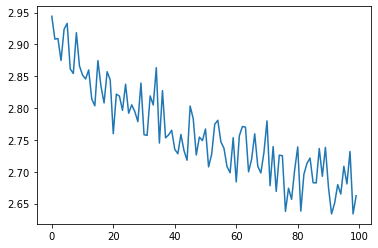

In [100]:
plt.plot(all_losses)

### 结果对比：  

 RNN ： 1层rnn ；1层i2o和i2h  学习率0.005； 10000轮运行时间 39s ； loss 2.1左右 
 
 RNN_n   ： 3层rnn ，学习率 0.0005 ； 100000轮运行时间 1m40 ； loss 2.5左右

 结论： 多层RNN，学习率若为0.005，运行后期会出现大幅度震荡现象；将学习率调整至0.0005会相对稳定下降，运行时间是单层的3倍；loss本例中效果没有单层表现好。

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

方便对比，本例继续用上例中的3层RNN，其他参数不变 ，只是将Loss funtion替换为 NLLoss


In [101]:
import torch
import torch.nn as nn             # 神经网络模块

In [102]:
rnn_n = nn.RNN(57, 128,3)   #字母维度

In [103]:
criterion = nn.NLLLoss()  #改nn.NLLoss

In [105]:
learning_rate = 0.0005 # If you set this too high, it might explode. If too low, it might not learn

def train_n(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量

    rnn_n.zero_grad()
    input = line_tensor       
    output, hidden = rnn_n(input) 

    for i in range(output.size()[0]):
        output_1 = output[i] 
        output_2 = i2o(output_1)
        output_3 = softmax(output_2)
   
    loss = criterion(output_3, category_tensor)      
    loss.backward(retain_graph=True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_n.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [106]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

i2o = nn.Linear(128, 18)
softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()    
    output, loss = train_n(category_tensor, line_tensor)                                   
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 5s) 2.9210 Ramires / Spanish ✗ (Portuguese)
1000 10% (0m 10s) 2.3863 Pitterman / Japanese ✗ (Czech)
1500 15% (0m 15s) 2.9357 Perez / Scottish ✗ (Spanish)
2000 20% (0m 20s) 2.4595 Shiratori / Japanese ✓
2500 25% (0m 25s) 3.0352 Masson / English ✗ (French)
3000 30% (0m 30s) 2.5427 Atamanenko / Czech ✗ (Russian)
3500 35% (0m 35s) 2.9587 Africani / Russian ✗ (Italian)
4000 40% (0m 40s) 2.8703 Corraidhin / Czech ✗ (Irish)
4500 45% (0m 46s) 2.5809 Kumagae / Russian ✗ (Japanese)
5000 50% (0m 51s) 2.6997 Cabral / English ✗ (Portuguese)
5500 55% (0m 56s) 2.4108 Hui / Korean ✗ (Chinese)
6000 60% (1m 1s) 3.2654 Cruz / Korean ✗ (Portuguese)
6500 65% (1m 6s) 2.2264 Wan / Korean ✗ (Chinese)
7000 70% (1m 11s) 3.1188 Asom / Chinese ✗ (English)
7500 75% (1m 17s) 2.6379 Schneijder / Russian ✗ (Dutch)
8000 80% (1m 23s) 1.8915 Youj / Chinese ✗ (Korean)
8500 85% (1m 29s) 2.5686 Crespo / English ✗ (Spanish)
9000 90% (1m 35s) 1.9542 Kim / Korean ✗ (Vietnamese)
9500 95% (1m 40s) 3.1297 Cham / Chine

In [107]:
all_losses

[2.90545786857605,
 2.967920844554901,
 2.991054720878601,
 2.9064087533950804,
 2.8901144790649416,
 2.908210015296936,
 2.954700834751129,
 2.860560164451599,
 2.861829800605774,
 2.9269891500473024,
 2.856652731895447,
 2.9570120310783388,
 2.870456881523132,
 2.8873942136764525,
 2.8832116770744323,
 2.8722487783432005,
 2.8223074579238894,
 2.8100200390815733,
 2.835174663066864,
 2.8380355644226074,
 2.8138533806800843,
 2.8317517924308775,
 2.867810717821121,
 2.7779568207263945,
 2.8093128037452697,
 2.8547202908992766,
 2.8191750848293307,
 2.7920139455795288,
 2.7336194527149202,
 2.7896106731891632,
 2.782912485599518,
 2.747701019048691,
 2.763291870355606,
 2.7353469371795653,
 2.794982681274414,
 2.770576561689377,
 2.7747445797920225,
 2.7278218126296996,
 2.701892813444138,
 2.7284899985790254,
 2.7242837142944336,
 2.7411483669281007,
 2.7652500915527343,
 2.7510741102695464,
 2.7497082591056823,
 2.759130917787552,
 2.754129822254181,
 2.691419289112091,
 2.7229814851

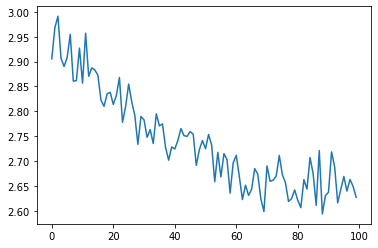

In [108]:
plt.plot(all_losses)

结论：

NLLLoss的结果就是把经过log_softmax函数的值与标签对应的那个值拿出来求和，再求平均，最后取取相反数。
直接使用pytorch中的loss_func=nn.CrossEntropyLoss()计算得到的结果与softmax-log-NLLLoss计算得到的结果是一致的。
